# RBF optimization

We first define the real function and the loss function:

[[ 2.9064357e-01 -3.3333333e+00  5.0000000e-01 -3.3333333e+00
   5.0000000e-01]
 [ 8.5482121e-02 -3.3333333e+00  5.0000000e-01 -1.6666664e+00
   5.0000000e-01]
 [ 9.9706483e-01 -3.3333333e+00  5.0000000e-01  3.8146973e-07
   5.0000000e-01]
 [ 7.1362007e-01 -3.3333333e+00  5.0000000e-01  1.6666672e+00
   5.0000000e-01]
 [ 1.5596008e-01 -3.3333333e+00  5.0000000e-01  3.3333344e+00
   5.0000000e-01]
 [ 1.2801719e-01 -1.6666664e+00  5.0000000e-01 -3.3333333e+00
   5.0000000e-01]
 [ 2.0627809e-01 -1.6666664e+00  5.0000000e-01 -1.6666664e+00
   5.0000000e-01]
 [ 9.1855621e-01 -1.6666664e+00  5.0000000e-01  3.8146973e-07
   5.0000000e-01]
 [ 3.5740137e-02 -1.6666664e+00  5.0000000e-01  1.6666672e+00
   5.0000000e-01]
 [ 1.7216587e-01 -1.6666664e+00  5.0000000e-01  3.3333344e+00
   5.0000000e-01]
 [ 7.2061563e-01  3.8146973e-07  5.0000000e-01 -3.3333333e+00
   5.0000000e-01]
 [ 4.4509602e-01  3.8146973e-07  5.0000000e-01 -1.6666664e+00
   5.0000000e-01]
 [ 6.1574686e-01  3.8146973e-07  5.00000

Training: 100%|██████████| 200/200 [02:44<00:00,  1.21it/s, Loss=0.0149]


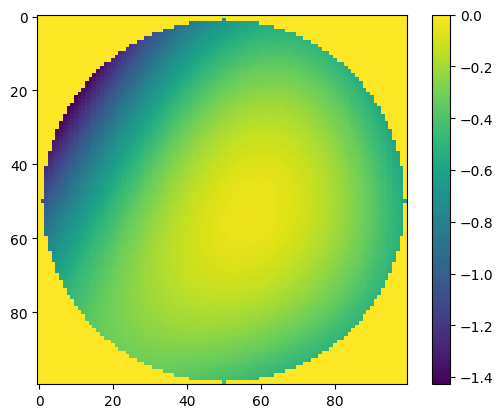

(100, 100)


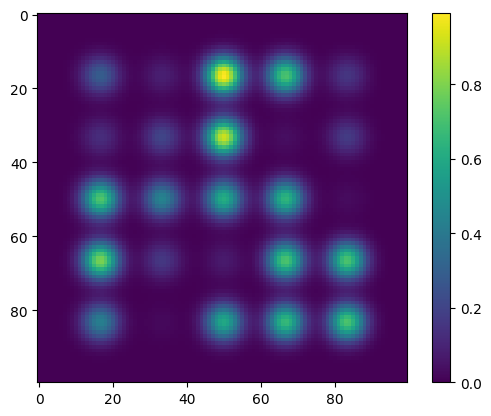

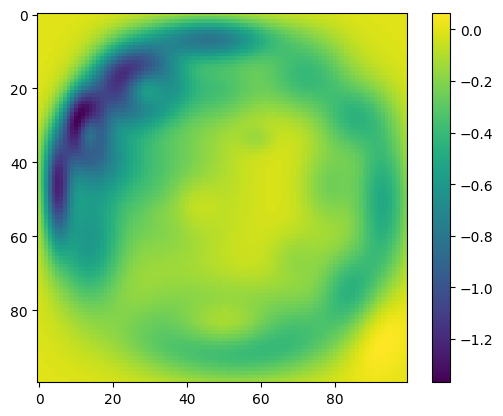

[[-4.1755500e-01 -4.2517743e+00  3.9520897e-03 -4.1853123e+00
   2.5585305e-02]
 [-1.8691218e+00 -2.0303781e+00  8.1957638e-01 -3.7734182e+00
   4.9039128e-01]
 [-2.8944641e-01 -2.9983966e+00 -9.3450552e-01 -9.7626768e-02
  -1.1494578e+00]
 [ 1.2861546e+00 -1.8497647e+00 -5.9317291e-01 -3.6888018e+00
  -3.3748594e-01]
 [-3.9369380e-01 -3.3420157e+00  1.0628858e+00  2.2237275e+00
   1.2162440e+00]
 [-9.7478175e-01 -2.9210743e-01  1.4253086e+00 -4.5022850e+00
   3.5595593e-01]
 [-2.3400404e+00 -3.1084263e+00  8.3860117e-01 -2.3593717e+00
   9.8888522e-01]
 [-3.5340920e-01 -2.2012241e+00 -9.0027881e-01  3.5191305e+00
  -8.8817328e-01]
 [-7.5413799e-01 -4.3259091e+00  5.6074113e-01 -4.0372229e-01
   1.7360387e+00]
 [ 5.3931825e-02 -1.5401696e+00 -4.4966419e-03  2.8327959e+00
  -1.1705549e-01]
 [ 3.1804968e-02  3.8889578e-01 -3.5307741e-01 -1.7471604e+00
  -3.1089953e-01]
 [ 1.7216096e+00 -3.0197377e+00 -6.0513121e-01 -2.2182376e+00
  -7.0733190e-01]
 [ 1.4586154e-01  1.2591004e-01 -7.55929

In [36]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random, grad
import optax
from typing import Tuple
from tqdm import tqdm

pix_sizes = jnp.array([0.1, 0.1])
shape = jnp.array([100, 100])
n_rbf = (5,5)

x = (jnp.arange(shape[0]) - shape[0] // 2) * pix_sizes[0]
y = (jnp.arange(shape[1]) - shape[1] // 2) * pix_sizes[1]
eps_original = ((1-0.5*(((x/x.max()))[None]**2 + (y/y.max())[:,None]**2)) - (1-0.5*(((x/x.max() -0.5))[None]**2 * (y/y.max() - 0.5)[:,None]))) * (1>=(((x/x.max()))[None]**2 + (y/y.max())[:,None]**2))
coords = jnp.array(jnp.meshgrid(y,x, indexing="ij")).transpose((1,2,0))


def rbf_init(
    pix_sizes: jnp.ndarray, 
    shape: jnp.ndarray, 
    n_rbf: Tuple[int,...],
    li: jnp.ndarray,
    key: int = 1
    ) -> jnp.ndarray:

    coords = pix_sizes * ((((jnp.array(jnp.meshgrid(*[jnp.arange(i) for i in n_rbf], indexing='ij')).reshape(len(n_rbf), -1) + 1) * (shape / (1 + jnp.array(n_rbf)))[:,None]).T) - (shape[None] // 2))
    li_arr = jnp.tile(li, (coords.shape[0], 1))
    keygen = random.key(key)

    weights = random.uniform(keygen, shape=(coords.shape[0],1), minval=0.0, maxval=1.0)
    params = jnp.concatenate(
        [weights, jnp.concat(
            [jnp.concat(
                [coords[:, i, None],li_arr[:, i, None]], 
                        axis=1) for i in range(len(n_rbf))], 
            axis=1)], 
        axis = 1)
    return params

def rbf_eval(
        rbf_params: jnp.ndarray,
        coords: jnp.ndarray
    ) -> jnp.ndarray:
    result = jnp.zeros_like(coords[:,:,0])
    for i in range(len(rbf_params)):
        dims = coords.shape[-1]
        dims_exp = dims*[None]
        result += rbf_params[i,0] * jnp.exp(-((coords - rbf_params[i,1::2][*dims_exp])**2/(rbf_params[i,2::2][*dims_exp])**2).sum(axis=-1))
    return result

def mse_loss(
        rbf_params: jnp.ndarray,
        coords: jnp.ndarray,
        ground_truth: jnp.ndarray
) -> jnp.ndarray:
    result = rbf_eval(rbf_params, coords)
    mse = jnp.mean((result - ground_truth)**2)
    return mse

    

rbf_params = rbf_init(pix_sizes, shape, n_rbf, li=jnp.array([0.5, 0.5]), key=8)
rbf_map = rbf_eval(rbf_params, coords)
mse = mse_loss(rbf_params, coords, eps_original)
print(rbf_params)
print(mse)

lr = 1e-1
n_epoch = 200
guess = rbf_init(pix_sizes, shape, n_rbf, li=jnp.array([0.5, 0.5]), key=8)
optimizer = optax.adam(lr)
opt_state = optimizer.init(guess)
seq_train = tqdm(range(n_epoch), desc="Training", leave=True)

for epoch in seq_train:

    gradient = grad(mse_loss, argnums=0)(guess, coords, eps_original)
    loss = mse_loss(guess, coords, eps_original)
    updates, opt_state = optimizer.update(gradient, opt_state)
    guess = optax.apply_updates(guess, updates)

    seq_train.set_postfix({"Loss": float(loss)})


plt.figure()
plt.imshow(eps_original)
plt.colorbar()
plt.show()

print(rbf_map.shape)
plt.figure()
plt.imshow(rbf_map)
plt.colorbar()
plt.show()

rbf_guessed = rbf_eval(guess, coords)
plt.figure()
plt.imshow(rbf_guessed)
plt.colorbar()
plt.show()
print(guess)

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training: 100%|██████████| 200/200 [03:14<00:00,  1.03it/s, Loss=0.0154]


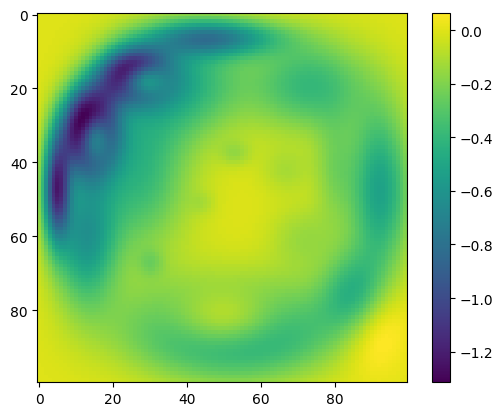

[[-4.23974067e-01 -4.25767708e+00 -1.48851541e-03 -4.89722776e+00
  -1.81279168e-03]
 [-1.83764935e+00 -3.32834315e+00  6.56026423e-01 -2.40162492e+00
   8.69426548e-01]
 [-4.17894721e-01 -3.12571883e+00 -1.41389060e+00 -1.05865121e+00
  -1.55580413e+00]
 [ 1.39294291e+00 -3.23816347e+00 -4.64810103e-01 -2.21417904e+00
  -6.44227684e-01]
 [-3.91155601e-01 -3.07482219e+00  1.24475181e+00  2.31872869e+00
   1.56973565e+00]
 [-1.03853929e+00 -3.08933467e-01  1.37980270e+00 -4.51651669e+00
   3.59546989e-01]
 [-2.38891554e+00 -1.84377611e+00  1.02553308e+00 -3.61248374e+00
   6.53537214e-01]
 [-1.03804819e-01 -7.57369459e-01 -6.14516556e-01  1.67766321e+00
  -6.93272829e-01]
 [-6.51263654e-01 -4.35690069e+00  5.01816511e-01 -2.82099336e-01
   1.76397061e+00]
 [-3.21423888e-01 -1.62411511e+00  3.92891109e-01  3.26882100e+00
   2.38294317e-03]
 [-1.11380331e-01  1.72763550e+00 -3.73208791e-01 -1.97318602e+00
  -3.49645674e-01]
 [ 1.71392608e+00 -1.70815957e+00 -7.25540996e-01 -3.52614450e+00

In [37]:
def rbf_grad(
        rbf_params: jnp.ndarray,
        coords: jnp.ndarray,
        ground_truth: jnp.ndarray
) -> jnp.ndarray:
    
    gradient = jnp.zeros_like(rbf_params)
    result = rbf_eval(rbf_params, coords)
    mse_err = 2 * (result - ground_truth)
    dims = coords.shape[-1]
    dims_exp = dims*[None]

    for i in range(len(rbf_params)):
        common_fact = jnp.exp(-jnp.sum((coords - rbf_params[i,1::2])**2/(rbf_params[i,2::2])**2, axis=-1))
        gradient = gradient.at[i,0].set((mse_err*common_fact).mean())
        gradient = gradient.at[i,1::2].set((mse_err[...,None] * common_fact[...,None] * 2 * rbf_params[i,0] * (coords-rbf_params[i,1::2][*dims_exp]) / (rbf_params[i,2::2][*dims_exp]**2)).mean(axis=(0,1)))
        gradient = gradient.at[i,2::2].set((mse_err[...,None] * common_fact[...,None] * 2 * rbf_params[i,0] * (coords-rbf_params[i,1::2][*dims_exp])**2 / (rbf_params[i,2::2][*dims_exp]**3)).mean(axis=(0,1)))
    return gradient


lr = 1e-1
n_epoch = 200
guess = rbf_init(pix_sizes, shape, n_rbf, li=jnp.array([0.5, 0.5]), key=8)
optimizer = optax.adam(lr)
opt_state = optimizer.init(guess)
seq_train = tqdm(range(n_epoch), desc="Training", leave=True)

for epoch in seq_train:

    #gradient = grad(mse_loss, argnums=0)(guess, coords, eps_original)
    gradient = rbf_grad(guess, coords, eps_original)
    loss = mse_loss(guess, coords, eps_original)
    updates, opt_state = optimizer.update(gradient, opt_state)
    guess = optax.apply_updates(guess, updates)

    seq_train.set_postfix({"Loss": float(loss)})

rbf_guessed = rbf_eval(guess, coords)
plt.figure()
plt.imshow(rbf_guessed)
plt.colorbar()
plt.show()
print(guess)

Now we plot the loss function:

In [4]:
shape = jnp.array([100,100,100])
pix_sizes = jnp.array([0.1, 0.1, 0.1])
n_rbf = (1, 2, 3)
li = jnp.array([2,2,2])
key = 50

coords = ((jnp.array(jnp.meshgrid(*[jnp.arange(i) for i in n_rbf], indexing='ij')).reshape(len(n_rbf), -1) + 1) * ((pix_sizes * shape) / (1 + jnp.array(n_rbf)))[:,None]).T
li_arr = jnp.tile(li, (coords.shape[0], 1))
keygen = random.key(key)

weights = random.uniform(keygen, shape=(coords.shape[0],1), minval=0.0, maxval=1.0)
params = jnp.concatenate(
    [weights, jnp.concat(
        [jnp.concat(
            [coords[:, i, None],li_arr[:, i, None]], 
                    axis=1) for i in range(len(n_rbf))], 
        axis=1)], 
    axis = 1)

print(params)

coords = jnp

[[0.7909913  5.         2.         3.3333335  2.         2.5
  2.        ]
 [0.7853776  5.         2.         3.3333335  2.         5.
  2.        ]
 [0.01631761 5.         2.         3.3333335  2.         7.5
  2.        ]
 [0.2583177  5.         2.         6.666667   2.         2.5
  2.        ]
 [0.08336914 5.         2.         6.666667   2.         5.
  2.        ]
 [0.77503145 5.         2.         6.666667   2.         7.5
  2.        ]]


In [12]:
a = jnp.arange(9).reshape(3,3)
b = 2*[None]
print(a[*b])
print(b)

[[[[0 1 2]
   [3 4 5]
   [6 7 8]]]]
[None, None]
